In [1]:
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen
from MIOFlow.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from MIOFlow.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:

##############################

# This cell holds general loss, regularization, and data creation functions.
# It also imports packages for the whole notebook.

##############################

!pip install scikit-network=='0.30.0'

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import colormaps as cm
import matplotlib.pyplot as plt

from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path
from sknetwork.path import get_shortest_path

# from sklearn.neighbors import NearestNeighbors


# Regularization, if desired
# Credit to HW1 code in CPSC 452

def lp_reg(params, p = 1, lamb = 0.001):
    """
    Compute the Lp regularization, in dimension p with lambda (factor) lamb.
    """
    total = 0
    for w in params:
        if len(w.shape) > 1: # if this isn't a bias
            total += torch.sum(torch.abs(w)**p)
    return lamb * (total ** (1/p))


# class for grouping data points with geodesics for training

class GeoDataset(torch.utils.data.Dataset):
    """
    Class for grouping batches of data points together with batches of geodesics for training.
    """
    def __init__(self, point_set, geo_set):
        self.point_set = point_set
        self.geo_set = geo_set

  
    def __getitem__(self, i):
        ratio = round(len(self.point_set) / len(self.geo_set))
        start_index = ratio * int(i)
        end_index = ratio * (int(i) + 1)
        return tuple([self.point_set[start_index:end_index], self.geo_set[i]])

    def __len__(self):
        return min(len(d) for d in [self.point_set, self.geo_set])


# sknetwork was just changed in version 0.31.0; currently using version 0.30.0

def find_geodesics(manifold, max_geo_count = None, knn = 10, geo_point_count = 10, sources = None):
    """
    Find a sampling of geodesics of the input data manifold, using graphs created with the
    input k-nearest neighbors. Find geodesics of different point lengths by specifying
    geo_point_count, and fin geodesics starting from specific points by specifying source indices,
    otherwise geodesics will start from a handful of random points.
    """
    graph = kneighbors_graph(manifold, n_neighbors = knn, mode = 'distance')

    num_nodes = graph.shape[0]

    # if no input sources, pick some randomly
    if not sources:
        sources = np.random.randint(0, num_nodes - 1, 2 * int(np.floor(np.sqrt(num_nodes))))

    indices = np.array(range(0, num_nodes))

    target_paths = []

    # for each input source, find some geodesics starting there
    for source in sources:
        other_nodes = indices[indices != source]
        paths = get_shortest_path(graph, sources = source, targets = other_nodes)
        target_paths += [path for path in paths if len(path) == geo_point_count]

    if not max_geo_count:
        max_geo_count = np.floor(((num_nodes / 10) + np.sqrt(num_nodes)) / 2)

    # return a random selection of the eligible geodesics
    num_selected = max_geo_count if max_geo_count < len(target_paths) else len(target_paths)
    selection_indices = np.random.choice(np.array(range(0, len(target_paths))), int(num_selected), replace=False)
    geodesics = torch.FloatTensor(np.array([manifold[path] for path in target_paths]))

    return geodesics[selection_indices]



# custom loss function for deviation of points from main line

class EndpointDistanceLoss(nn.Module):
    """
    Loss function for straightening geodesic curves when encoding into latent space.
    """
    def __init__(self, keep_geo_dist = True, lamb_s = 1):
        super(EndpointDistanceLoss, self).__init__()

        self.keep_geo_dist = keep_geo_dist
        self.lamb_s = lamb_s

    def forward(self, output, target = None):
        # find dimensions of batch data
        batch_size = output.size()[0]
        line_end = output.size()[1] - 1
        space_dimension = output.size()[2]

        # for avoiding division by 0
        epsilon = 0.000001e-10

        # subtract each first vector from line in all lines
        subs = torch.sub(output, output[:, 0].reshape(batch_size, 1, space_dimension))

        # find norm of the endpoint vector of each line
        lengths = torch.linalg.vector_norm(subs[:, line_end], dim=(1))

        # divide points of each line by its norm
        norms = torch.div(subs, lengths.reshape(batch_size, 1, 1) + epsilon)

        # dot each normalized line into normalized endpoint
        dots = torch.bmm(norms, norms[:, line_end].reshape(batch_size, space_dimension, -1))

        # scale each normalized line with the line's vector's scalar projections
        projs = torch.mul(dots, subs[:, line_end].reshape(batch_size, 1, space_dimension))

        # find deviations of each projected point from its output point
        deviations = torch.sub(subs, projs)

        # find means of deviation lengths for the batch
        dev_lengths = torch.linalg.vector_norm(deviations, dim=(2))
        loss = torch.mean(dev_lengths)

        # also encourage lengths of straight lines to match lengths of geodesics (or not, in which case have even segment lengths)

        if target != None and self.keep_geo_dist:

            # find segment vectors
            segments = torch.sub(output[:, 1:], output[:, 0:line_end])
            target_segments = torch.sub(target[:, 1:], target[:, 0:line_end])

            # take the norms
            segment_lengths = torch.linalg.vector_norm(segments, dim=(2))
            target_segment_lengths = torch.linalg.vector_norm(segments, dim=(2))

            # compare total lengths of geodesics as well
            target_total_lengths = torch.sum(target_segment_lengths, dim = 1)

            # find the difference between lengths of each pair of segments
            segment_diffs = segment_lengths - target_segment_lengths
            total_length_diffs = target_total_lengths - lengths

            # use mse of differences
            # loss += torch.mean((segment_diffs)**2)
            loss += torch.mean((total_length_diffs)**2)


        # if not keeping distances, make segments lengths even
        elif not self.keep_geo_dist:
            # find segment vectors
            segments = torch.sub(output[:, 1:], output[:, 0:line_end])

            # take the norms
            segment_lengths = torch.linalg.vector_norm(segments, dim=(2))

            loss += torch.mean(torch.std(segment_lengths, dim=1))

        return loss * self.lamb_s


class NearestNeighborsLoss(nn.Module):
    """
    Loss function using the mean squared error of the differences between the distances to the nearest neighbors of each point,
    before and after dimensionality reduction ('output' is after reduction, 'target' is original manifold), or by simply keeping
    the nearest neighbors around the same points.
    """

    def __init__(self, nn = 20, keep_dist = False, make_even = False, lamb_k = 1, lamb_d = 1, lamb_e = 1):
        super(NearestNeighborsLoss, self).__init__()

        self.keep_dist = keep_dist
        self.make_even = make_even
        self.nn = nn
        self.lamb_k = lamb_k
        self.lamb_d = lamb_d
        self.lamb_e = lamb_e


    def forward(self, output, target):

        # check that neighbor distances in encoding are similar to original neighbor distances

        batch_size = output.size()[0]
        latent_dim = output.size()[1]
        ambient_dim = target.size()[1]
        nn_count = self.nn

        # find neighbors of output
        subs = output - output.reshape(batch_size, 1, latent_dim)
        dists = torch.norm(subs, dim=2, p=None)
        knn = dists.topk(nn_count + 1, largest=False)
        output_nn_dists = knn.values[:, 1:]
        output_nn_indices = knn.indices[:, 1:]

        # find vectors of neighbors from each point for cosine similarity
        batch_index = torch.arange(batch_size).view(batch_size, 1)
        knn_output_vectors = subs[batch_index, output_nn_indices]

        # repeat for targets
        subs = target - target.reshape(batch_size, 1, ambient_dim)
        dists = torch.norm(subs, dim=2, p=None)
        knn = dists.topk(nn_count + 1, largest=False)
        target_nn_dists = knn.values[:, 1:]
        target_nn_indices = knn.indices[:, 1:]

        diff = 0

        if self.keep_dist:
            # calculate distances
            # diff += torch.mean((target_nn_dists - output_nn_dists)**2)
            diff += self.lamb_d * (torch.mean(target_nn_dists) - torch.mean(output_nn_dists))**2

        if self.make_even:
            diff += self.lamb_e * torch.std(torch.mean(output_nn_dists, dim = 1)).clone()

        # to find the number of nearest neighbors in common

        nn_bools = torch.eq(output_nn_indices.reshape(batch_size, nn_count, 1), target_nn_indices.reshape(batch_size, 1, nn_count))
        diff += self.lamb_k * ((batch_size * nn_count) - torch.sum(nn_bools)) / (batch_size * nn_count)

        return diff

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
import torch
import torch.nn as nn

class ParameterAE(nn.Module):
    """
    Autoencoder model for finding a latent space.
    If embed is True, the model will encode the input data and output the latent embedding.
    If skip is True, the model will use skip connections between the encoder and decoder (recommended).
    If res is true, the model will use skip connections within the encoder and decoder (not currently recommended).
    """
    def __init__(self, embed=False, res=False, skip=False, hidden_dim=64, input_dim=3):
        super(ParameterAE, self).__init__()

        # store booleans for different model options
        self.embed = embed
        self.res = res
        self.skip = skip
        self.skip1 = None
        self.skip2 = None
        self.skip3 = None
        self.skip4 = None
        self.skip5 = None

        # using leaky relu, silu, tanh

        self.enc_lin1 = nn.Linear(input_dim, hidden_dim)
        self.enc_nonlin1 = nn.LeakyReLU()
        self.enc_lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.enc_nonlin2 = nn.SiLU()
        self.enc_lin3 = nn.Linear(hidden_dim, hidden_dim)
        self.enc_nonlin3 = nn.Tanh()
        self.enc_lin4 = nn.Linear(hidden_dim, hidden_dim)
        self.enc_nonlin4 = nn.SiLU()
        self.enc_lin5 = nn.Linear(hidden_dim, hidden_dim)
        self.enc_nonlin5 = nn.LeakyReLU()
        self.enc_lin6 = nn.Linear(hidden_dim, 2)

        self.dec_lin1 = nn.Linear(2, hidden_dim)
        self.dec_nonlin1 = nn.LeakyReLU()
        self.dec_lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.dec_nonlin2 = nn.SiLU()
        self.dec_lin3 = nn.Linear(hidden_dim, hidden_dim)
        self.dec_nonlin3 = nn.Tanh()
        self.dec_lin4 = nn.Linear(hidden_dim, hidden_dim)
        self.dec_nonlin4 = nn.SiLU()
        self.dec_lin5 = nn.Linear(hidden_dim, hidden_dim)
        self.dec_nonlin5 = nn.LeakyReLU()
        self.dec_lin6 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        if self.res:
            x = self.enc_lin1(x)
            x = x + self.enc_nonlin1(x)
            if self.skip:
                self.skip1 = x
            x = x + self.enc_lin2(x)
            x = x + self.enc_nonlin2(x)
            if self.skip:
                self.skip2 = x
            x = x + self.enc_lin3(x)
            x = x + self.enc_nonlin3(x)
            if self.skip:
                self.skip3 = x
            x = x + self.enc_lin4(x)
            x = x + self.enc_nonlin4(x)
            if self.skip:
                self.skip4 = x
            x = x + self.enc_lin5(x)
            x = x + self.enc_nonlin5(x)
            if self.skip:
                self.skip5 = x
            x = self.enc_lin6(x)
            return x
        
        x = self.enc_lin1(x)
        x = self.enc_nonlin1(x)
        if self.skip:
            self.skip1 = x
        x = self.enc_lin2(x)
        x = self.enc_nonlin2(x)
        if self.skip:
            self.skip2 = x
        x = self.enc_lin3(x)
        x = self.enc_nonlin3(x)
        if self.skip:
            self.skip3 = x
        x = self.enc_lin4(x)
        x = self.enc_nonlin4(x)
        if self.skip:
            self.skip4 = x
        x = self.enc_lin5(x)
        x = self.enc_nonlin5(x)
        if self.skip:
            self.skip5 = x
        x = self.enc_lin6(x)

        return x

    def decode(self, x):
        if self.res:
            x = self.dec_lin1(x)
            if self.skip:
                x += self.skip5
            x = x + self.dec_nonlin1(x)
            x = x + self.dec_lin2(x)
            if self.skip:
                x += self.skip4
            x = x + self.dec_nonlin2(x)
            x = x + self.dec_lin3(x)
            if self.skip:
                x += self.skip3
            x = x + self.dec_nonlin3(x)
            x = x + self.dec_lin4(x)
            if self.skip:
                x += self.skip2
            x = x + self.dec_nonlin4(x)
            x = x + self.dec_lin5(x)
            if self.skip:
                x += self.skip1
            x = x + self.dec_nonlin5(x)
            x = self.dec_lin6(x)
            return x
        
        x = self.dec_lin1(x)
        if self.skip:
            x += self.skip5
        x = self.dec_nonlin1(x)
        x = self.dec_lin2(x)
        if self.skip:
            x += self.skip4
        x = self.dec_nonlin2(x)
        x = self.dec_lin3(x)
        if self.skip:
            x += self.skip3
        x = self.dec_nonlin3(x)
        x = self.dec_lin4(x)
        if self.skip:
            x += self.skip2
        x = self.dec_nonlin4(x)
        x = self.dec_lin5(x)
        if self.skip:
            x += self.skip1
        x = self.dec_nonlin5(x)
        x = self.dec_lin6(x)

        return x


    def forward(self, x):
        x = self.encode(x)
        if self.embed:
            return x
        x = self.decode(x)
        return x


def train(model, device, train_loader, encode_loss, geo_loss, decode_loss, optimizer, epochs, pre_tr_epochs=None, p=None, lamb=None):
    """
    The main training function for the model. Training can be separated into two parts, pretraining and regular training.
    Pretraining focuses on creating the parameter space and trains with geodesics and free data points, while regular
    training focuses on smoothing the parameter space by training with just the free data points. Training patterns vary
    by manifold.
    """

    # Pretraining

    # set learning rate decay
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.98)

    if pre_tr_epochs:
        for epoch in range(pre_tr_epochs):
            model, train_loss = train_data_epoch(model, device, train_loader, encode_loss, decode_loss, optimizer, p, lamb)
            model, train_loss2 = train_geo_epoch(model, device, train_loader, geo_loss, optimizer)
            train_loss += train_loss2

            if (epoch + 1) % 10 == 0:
                print(f"\rPretraining Epoch: {epoch + 1} \t Average Loss: {train_loss:.6f}")

                # step learning rate every 10 epochs
                lr_scheduler.step()

    # Training

    # set learning rate decay
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.98)

    # iterate over epochs
    for epoch in range(epochs):
        model, train_loss = train_data_epoch(model, device, train_loader, encode_loss, decode_loss, optimizer, p, lamb)

        if (epoch + 1) % 10 == 0:
            print(f"\rEpoch: {epoch + 1} \t Average Loss: {train_loss:.6f}")

            # step learning rate every 10 epochs
            lr_scheduler.step()

    return model


# function for training an epoch with data points

def train_data_epoch(model, device, train_loader, encode_loss, decode_loss, optimizer, p=None, lamb=None):
    """
    Train the model with the data points themselves, using the nearest neighbors and reconstruction losses.
    """

    # set model to train, set train loss to 0
    model.train()
    train_loss = 0

    # iterate over batches
    for batch_index, batch in enumerate(train_loader):
        # separate point data and geo data
        points, geos = batch
        point_data, point_target = points
        point_data, point_target = point_data.reshape(-1, point_data.size()[2]).to(device), point_target.reshape(
            -1, point_target.size()[2]).to(device)

        # set optimizer
        optimizer.zero_grad()

        # find outputs for embedding and reconstruction, calculate loss, backpropagate, step optimizer
        model.embed = True
        output = model(point_data)
        loss = encode_loss(output, point_target)
        model.embed = False
        output = model(point_data)
        loss += decode_loss(output, point_target)

        # add regularization if desired
        if p and lamb:
            loss += lp_reg(model.parameters(), p, lamb)
        elif p:
            loss += lp_reg(model.parameters(), p)
        elif lamb:
            loss += lp_reg(model.parameters(), lamb=lamb)

        loss.backward()
        optimizer.step()

        # keep track of training loss
        train_loss += loss.item()

    return model, (train_loss / len(train_loader))


# function for training an epoch with geodesics

def train_geo_epoch(model, device, train_loader, geo_loss, optimizer):
    """
    Train the model with the geodesics, using the geodesic straightening loss.
    """

    model.train()
    train_loss = 0

    for batch_index, batch in enumerate(train_loader):
        # separate point data and geo data
        points, geos = batch
        geo_data, geo_target = geos
        geo_data, geo_target = geo_data.to(device), geo_target.to(device)

        # train geodesic straightening
        optimizer.zero_grad()

        model.embed = True
        output = model(geo_data)
        loss = geo_loss(output, geo_target)

        loss.backward()
        optimizer.step()

        # # keep track of training loss
        train_loss += loss.item()

    return model, (train_loss / len(train_loader))

In [4]:
# cell data points
cells = pd.read_csv("~/MIOFlow/notebooks/dyngen_PCs.csv")
cell_data = cells[['d1', 'd2', 'd3', 'd4', 'd5']].to_numpy()

In [5]:
from sklearn.preprocessing import StandardScaler

# #pca values and components
# pca_loadings = np.load('/Users/davidmetrick/Downloads/pca_loadings.npy')
# pca_components = np.load('/Users/davidmetrick/Downloads/pca_components.npy')

# geodesics
traj_geos = np.load('/Users/davidmetrick/MIOFlow/results/dyngen_embcomp/trajectories_noemb.npy') # change to appropriate GitHub address

scaler = StandardScaler()
scaler.fit(cells) # changed from pca_loadings
geos = traj_geos * scaler.scale_[:5] + scaler.mean_[:5]

geos = np.transpose(geos, (1, 0, 2))
print(geos.shape)

(100, 5100, 5)


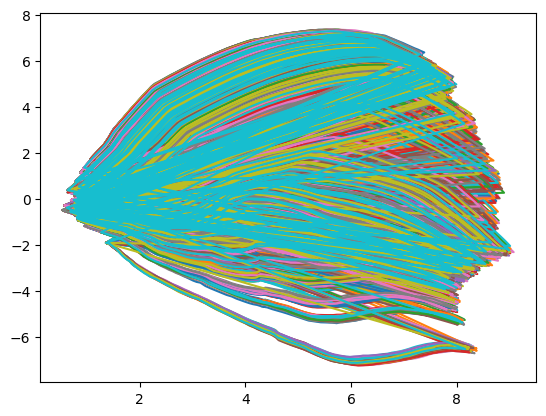

In [6]:
fig, ax = plt.subplots(1, 1)

for i in range(100):
    ax.plot(geos[i,:,0], geos[i,:,1])

plt.show()

In [7]:
indices = [0, 25, 50, 75, 99]
trimmed_geos = geos[:, indices, :]
print(trimmed_geos.shape)

(100, 5, 5)


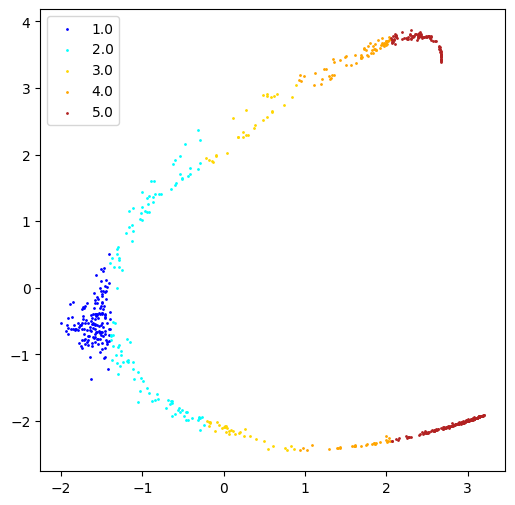

In [8]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1)
cdict = {1.0: 'blue',
        2.0: 'aqua',
        3.0: 'gold',
        4.0: 'orange',
        5.0: 'firebrick'}

clist = ['blue', 'light blue', 'teal ', 'aquamarine', 'red']

for day in cdict.keys():
    ax.scatter(cells[cells['samples'] == day]['d1'], cells[cells['samples'] == day]['d2'], c = cdict[day], s=1, label=day)
ax.legend()

plt.show()

In [9]:
labels = cells['samples'].to_numpy()
days = np.array([[1.0, 2.0, 3.0, 4.0, 5.0]])
geo_times = np.repeat(days, 800, axis = 0)
labels = np.concatenate((labels, geo_times.reshape(-1)))
print(labels.shape)

(4728,)


In [10]:
# Set up the model for dyngen data

batch_size = 80
# geo_batch_size = 50
learning_rate = 0.001
pre_epochs = 300 # originally 100
epochs = 0


# set gpu/cpu device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


# assemble data

data = torch.FloatTensor(cell_data)
geodesics = torch.FloatTensor(trimmed_geos[:800])

data = torch.cat((data, geodesics.reshape(-1, 5)), dim=0)


train_dataset = torch.utils.data.TensorDataset(data, data)
geo_dataset = torch.utils.data.TensorDataset(geodesics, geodesics)
test_dataset = GeoDataset(train_dataset, geo_dataset)

train_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [11]:
model = ParameterAE(input_dim = 5, hidden_dim = 128, skip = True).to(device)
loss_function = NearestNeighborsLoss(nn = 28, keep_dist = True, make_even = True) # changed from 250
loss_function2 = nn.MSELoss()
loss_function_geo = EndpointDistanceLoss(keep_geo_dist = False)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = train(model, device, train_loader, loss_function, loss_function_geo, loss_function2,
              optimizer, epochs, pre_tr_epochs = pre_epochs, p = 2, lamb = 0.01)

model.to(device)

# Save the model
torch.save(model.state_dict(), 'model.pth')

# Load the model
model = ParameterAE(input_dim = 5, hidden_dim = 128, skip = True).to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()

Pretraining Epoch: 10 	 Average Loss: 1.423626
Pretraining Epoch: 20 	 Average Loss: 1.070100
Pretraining Epoch: 30 	 Average Loss: 0.970550
Pretraining Epoch: 40 	 Average Loss: 0.896372
Pretraining Epoch: 50 	 Average Loss: 0.817446
Pretraining Epoch: 60 	 Average Loss: 0.792692
Pretraining Epoch: 70 	 Average Loss: 0.815471
Pretraining Epoch: 80 	 Average Loss: 0.810430
Pretraining Epoch: 90 	 Average Loss: 0.751560
Pretraining Epoch: 100 	 Average Loss: 0.836506
Pretraining Epoch: 110 	 Average Loss: 1.064115
Pretraining Epoch: 120 	 Average Loss: 0.760432
Pretraining Epoch: 130 	 Average Loss: 0.878603
Pretraining Epoch: 140 	 Average Loss: 0.766712
Pretraining Epoch: 150 	 Average Loss: 0.737079
Pretraining Epoch: 160 	 Average Loss: 0.684465
Pretraining Epoch: 170 	 Average Loss: 0.671650
Pretraining Epoch: 180 	 Average Loss: 0.718288
Pretraining Epoch: 190 	 Average Loss: 0.699644
Pretraining Epoch: 200 	 Average Loss: 0.675322
Pretraining Epoch: 210 	 Average Loss: 0.682990
P

ParameterAE(
  (enc_lin1): Linear(in_features=5, out_features=128, bias=True)
  (enc_nonlin1): LeakyReLU(negative_slope=0.01)
  (enc_lin2): Linear(in_features=128, out_features=128, bias=True)
  (enc_nonlin2): SiLU()
  (enc_lin3): Linear(in_features=128, out_features=128, bias=True)
  (enc_nonlin3): Tanh()
  (enc_lin4): Linear(in_features=128, out_features=128, bias=True)
  (enc_nonlin4): SiLU()
  (enc_lin5): Linear(in_features=128, out_features=128, bias=True)
  (enc_nonlin5): LeakyReLU(negative_slope=0.01)
  (enc_lin6): Linear(in_features=128, out_features=2, bias=True)
  (dec_lin1): Linear(in_features=2, out_features=128, bias=True)
  (dec_nonlin1): LeakyReLU(negative_slope=0.01)
  (dec_lin2): Linear(in_features=128, out_features=128, bias=True)
  (dec_nonlin2): SiLU()
  (dec_lin3): Linear(in_features=128, out_features=128, bias=True)
  (dec_nonlin3): Tanh()
  (dec_lin4): Linear(in_features=128, out_features=128, bias=True)
  (dec_nonlin4): SiLU()
  (dec_lin5): Linear(in_features=12

/var/folders/35/5xfzrq_d7y3bf6rdnz9jd2fr0000gn/T/ipykernel_30914/1110926358.py:28: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343686130/work/aten/src/ATen/native/TensorShape.cpp:3575.)
  ax2.plot(curves[0:100].T[0], curves[0:100].T[1])


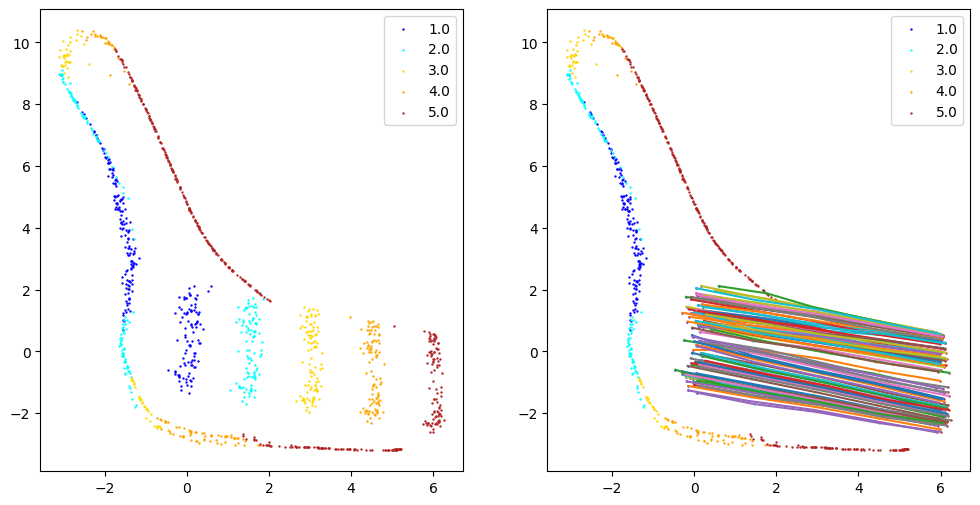

In [12]:
model.embed = True
model.eval()

# original_cells = torch.FloatTensor(cell_data)

output = model.to('cpu')(data).detach()
curves = model(geodesics).detach()

# for plots of 2D parameter spaces

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

cdict = {1.0: 'blue',
        2.0: 'aqua',
        3.0: 'gold',
        4.0: 'orange',
        5.0: 'firebrick'}

clist = ['blue', 'teal', 'yellow', 'orange', 'red']

for day in cdict.keys():
    length = len(output.T[0])
    indices = [labels == day][0][:length]
    ax1.scatter(output.T[0][indices], output.T[1][indices], s=50/100, c=cdict[day], label=day)
    ax2.scatter(output.T[0][indices], output.T[1][indices], s=50/100, c=cdict[day], label=day)
ax2.plot(curves[0:100].T[0], curves[0:100].T[1])
ax1.legend()
ax2.legend()
plt.show()